<a href="https://colab.research.google.com/github/bolaris-sage/shark-research/blob/main/shark-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This analysis explores the behavior of a female great white shark around Guadalupe Island, offering insights into shark ecology crucial for marine conservation efforts. The data, collected from 15th to 23rd October 2017, spanning a 9-day period, includes readings from pressure, temperature, and a 3-axis accelerometer sensors. This study focuses on interpreting the relationship between her depth, surrounding environmental conditions, and movement behaviors during this period. By utilizing interactive visualization tools, we aim to unravel the complex patterns in her movements, offering insights into shark ecology and aiding marine conservation by addressing specific questions such as how environmental conditions influence the shark's depth and movement.

## Data Overview
CEFAS 1 Female 4.5
- **Deployment Duration**: October 15, 2017 - October 23, 2017
- **Tag ID**: A14243
- **Firmware**: Version 3, Build Level 70
- **Sensors Count**: 5
- **Sensors**: Pressure (measuring depth), Temperature, 3-axis accelerometer (tracking movement)
- **Logging Rate**: 1 per second
- **Resolution**: 12 bits
- **Pressure Range**: 50 units
- **G range selected**: 2g
- **Wet dry logging**: Inhibited
- **Logging of Dive data**: Active
- **Dive Termination**: 1.5% percentage, 7.5m depth

The dataset contains time-stamped measurements of pressure, temperature, and tri-axial acceleration. These metrics are used to assess the shark's movement behavior. The accelerometer data is particularly vital for understanding the shark's energy expenditure and movement patterns. The 1-second logging rate allows for capturing the fine-scale movements of the shark, providing a detailed temporal resolution crucial for analyzing behavior patterns.


# Analysis

## Import Libraries

In [1]:
# Install Astral (if needed)
!pip install astral --quiet

# Import necessary libraries
from datetime import date, datetime, timedelta
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pytz import timezone
from astral import LocationInfo
from astral.sun import sun, dawn, dusk
from matplotlib.colors import LinearSegmentedColormap

## Data Loading

In [2]:
# This section checks if the notebook is running on Google Colab and sets the base path accordingly.
running_on_colab = 'google.colab' in sys.modules

if running_on_colab:
    # Google Colab specific imports
    from google.colab import auth, drive

    # Authenticate and mount the drive
    auth.authenticate_user()
    drive.mount('/content/drive')

    # Set the base path for data on Google Drive
    base_path = '/content/drive/MyDrive/shark-data/'
else:
    # Set the base path for local data
    base_path = 'C:/shared/shark-data/'

# Now you can load your data using the base path
data_file_path = os.path.join(base_path, 'A14243_23-10-2017.csv')

# Load the data
data = pd.read_csv(data_file_path, skiprows=59)

# Check if data loaded correctly
if data.empty:
    raise ValueError("Data failed to load or is empty.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Cleaning

In [3]:
import numpy as np

# Convert 'Time Stamp' to datetime and drop rows with invalid dates
initial_count = data.shape[0]
data['Time Stamp'] = pd.to_datetime(data['Time Stamp'], format='%d/%m/%y %H:%M', errors='coerce')

valid_mask = data['Time Stamp'].notna() & data['Pressure'].notna() & (data['Pressure'] != np.inf) & data['Temp'].notna() & (data['Temp'] != np.inf) & (data['Temp'] != -np.inf)

# Keeping a copy of the dropped data for potential review or audit of the cleaning process
dropped_data = data[~valid_mask]

# Filter for valid data
data = data[valid_mask]

# Summary of dropped data
dropped_due_to_invalid_values = len(dropped_data)

print(f"Total initial events: {initial_count}")
print(f"Dropped due to invalid values: {dropped_due_to_invalid_values}")
print(f"Remaining events after cleaning: {data.shape[0]}")

# Display a sample of dropped data for verification
#print("Sample of data dropped:")
#print(dropped_data.head())

Total initial events: 700624
Dropped due to invalid values: 4
Remaining events after cleaning: 700620


## Data Transformation

### Calculating ODBA
ODBA is calculated to represent shark's locomotor activity, serving as an energy expenditure proxy.

In [4]:
# Ensure data is a copy to avoid SettingWithCopyWarning
data = data.copy()

# Chosen window size of 5 for the rolling mean of ODBA balances between capturing detailed activity fluctuations and smoothing out short-term noise.
window_size = 5

# Calculate ODBA as a proxy for the shark's energy expenditure, reflecting its locomotor activity
data['ODBA'] = (data[['X Axis', 'Y Axis', 'Z Axis']] -
                data[['X Axis', 'Y Axis', 'Z Axis']].rolling(window=window_size).mean()).abs().sum(axis=1)

### Calculating Day-Night Cycle Times

In [5]:
# Define the location and timezone for sunrise/sunset calculations
guadalupe_coords = {'latitude': 29.020879, 'longitude': -118.273103}
city = LocationInfo('Ensenada', 'Mexico', 'America/Tijuana', guadalupe_coords['latitude'], guadalupe_coords['longitude'])
local_tz = timezone('America/Tijuana')

# Cache the observer since it doesn't change
observer = city.observer

# Custom function to calculate sunrise, sunset, and nautical twilight
def calculate_sun_cycles(current_date):
    sun_times = sun(observer, date=current_date, tzinfo=local_tz)
    nautical_start = dawn(observer, date=current_date, tzinfo=local_tz)
    nautical_end = dusk(observer, date=current_date, tzinfo=local_tz)

    return {
        'sunrise': sun_times['sunrise'].replace(tzinfo=None),
        'sunset': sun_times['sunset'].replace(tzinfo=None),
        'nautical_twilight_start': nautical_start.replace(tzinfo=None),
        'nautical_twilight_end': nautical_end.replace(tzinfo=None)
    }

# Custom function to plot day, night, and nautical twilight bands
def plot_day_night_bands(sun_cycles, ax, include_twilight=True):
    # Iterate over the sun cycles with index for labeling
    for idx, (current_date, times) in enumerate(sun_cycles.items()):
        # Extract the sunrise and sunset times
        sunrise, sunset = times['sunrise'], times['sunset']

        # Plot day band, label only on first cycle
        ax.axvspan(sunrise, sunset, color='#FFFF00', alpha=0.15, label='Day' if idx == 0 else "")

        # Include twilight bands, label only on first cycle
        if include_twilight:
            nautical_start, nautical_end = times['nautical_twilight_start'], times['nautical_twilight_end']
            ax.axvspan(nautical_start, sunrise, color='orange', alpha=0.1, label='Twilight' if idx == 0 else "")
            ax.axvspan(sunset, nautical_end, color='orange', alpha=0.1)

        # Plot night band, label only on first cycle, avoid plotting for the last day
        if idx < len(sun_cycles) - 1:
            next_day_sunrise = sun_cycles[date.fromordinal(current_date.toordinal() + 1)]['sunrise']
            ax.axvspan(sunset, next_day_sunrise, color='black', alpha=0.1, label='Night' if idx == 0 else "")

# Use the data to calculate sun cycles (this assumes 'data' is a pre-existing DataFrame)
data['Date'] = data['Time Stamp'].dt.date
sun_cycles = {current_date: calculate_sun_cycles(current_date) for current_date in data['Date'].unique()}

## Data Visualization

### Depth over Time with Temperature Color Coding and Day/Night Bands
Depth over time graph, with temperature color-coding and day/night bands, illustrates how sharks' movement patterns are influenced by environmental and temporal factors.

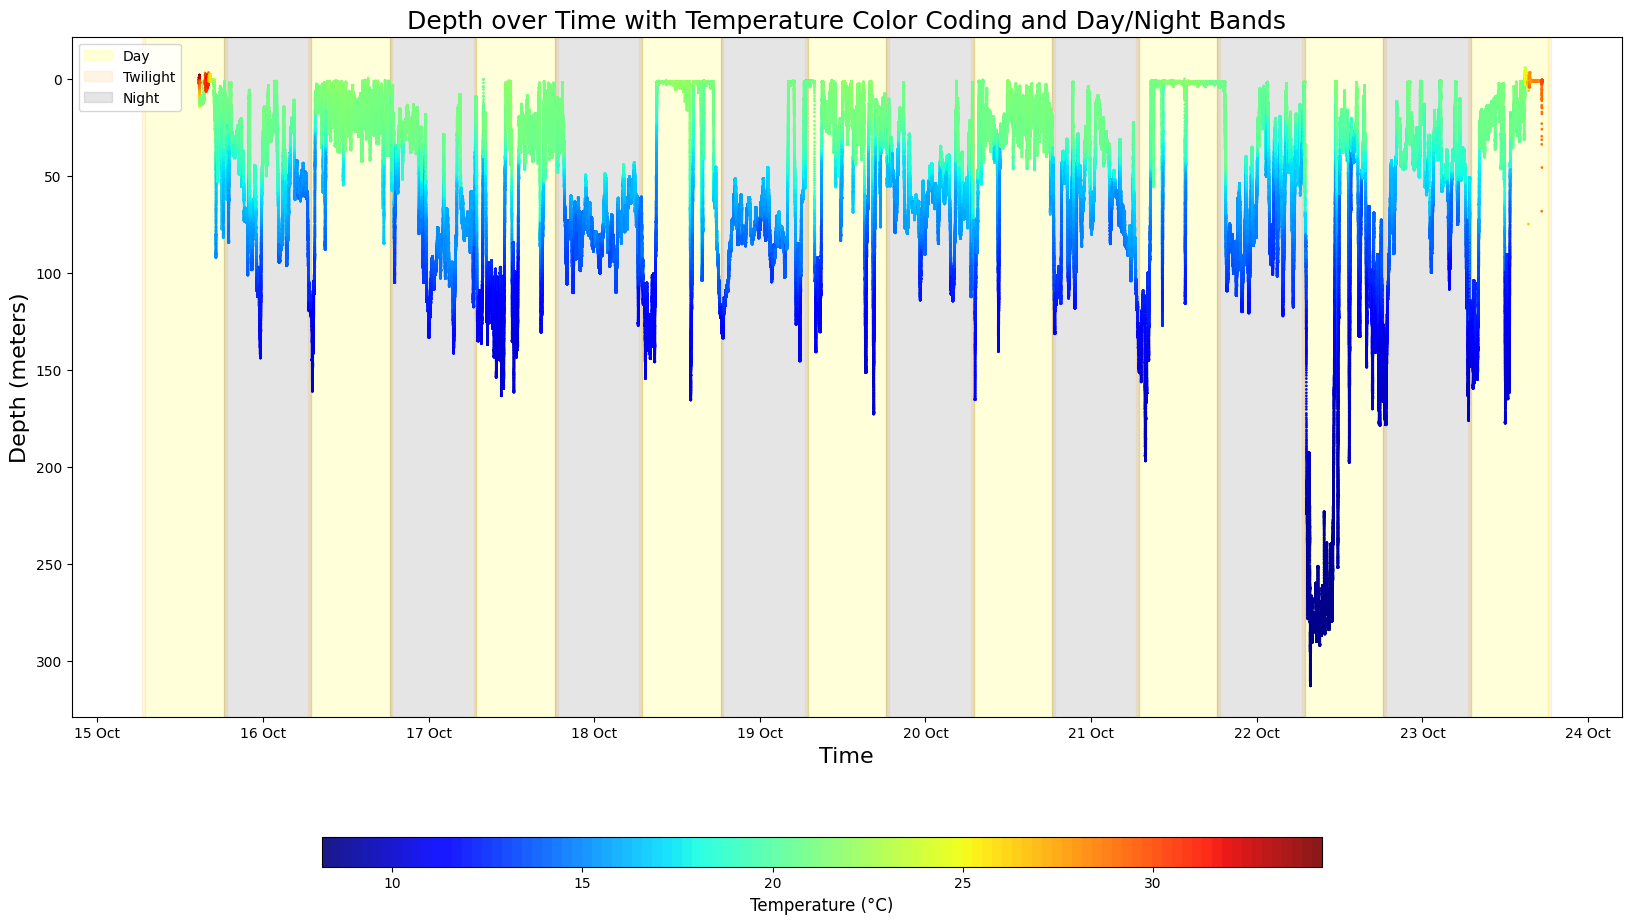

In [6]:
# Set plot titles and labels
plt.figure(figsize=(20, 10))
plt.xlabel('Time', fontsize=16)
plt.ylabel('Depth (meters)', fontsize=16)
plt.title('Depth over Time with Temperature Color Coding and Day/Night Bands', fontsize=18)

# Plot day-night bands
plot_day_night_bands(sun_cycles, plt.gca())

# Use a predefined colormap
cmap = plt.get_cmap('jet', 100)
norm = plt.Normalize(vmin=data['Temp'].min(), vmax=data['Temp'].max())

# Plot depth data against time, colored by temperature
sc = plt.scatter(data['Time Stamp'], data['Pressure'], c=data['Temp'], cmap=cmap, norm=norm, s=1, alpha=0.9)

# Make increased depth down
plt.gca().invert_yaxis()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Extract handles and labels for the legend from the current axis
handles, labels = plt.gca().get_legend_handles_labels()

# Create legend from handles and labels
plt.legend(handles, labels, loc='upper left')

# Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.20)

# Adjust the position of the colorbar
colorbar_axes = plt.gcf().add_axes([0.25, 0.05, 0.5, 0.03])

# Create the colorbar with the specified axes and orientation
cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')

# Set the label for the colorbar
cbar.set_label('Temperature (°C)', fontsize=12)

# Show the plot
plt.show()

### ODBA over Time with Day/Night Bands
The graph shows sharks' Overall Dynamic Body Acceleration (ODBA) over time, marked with day (yellow) and night (black) bands.

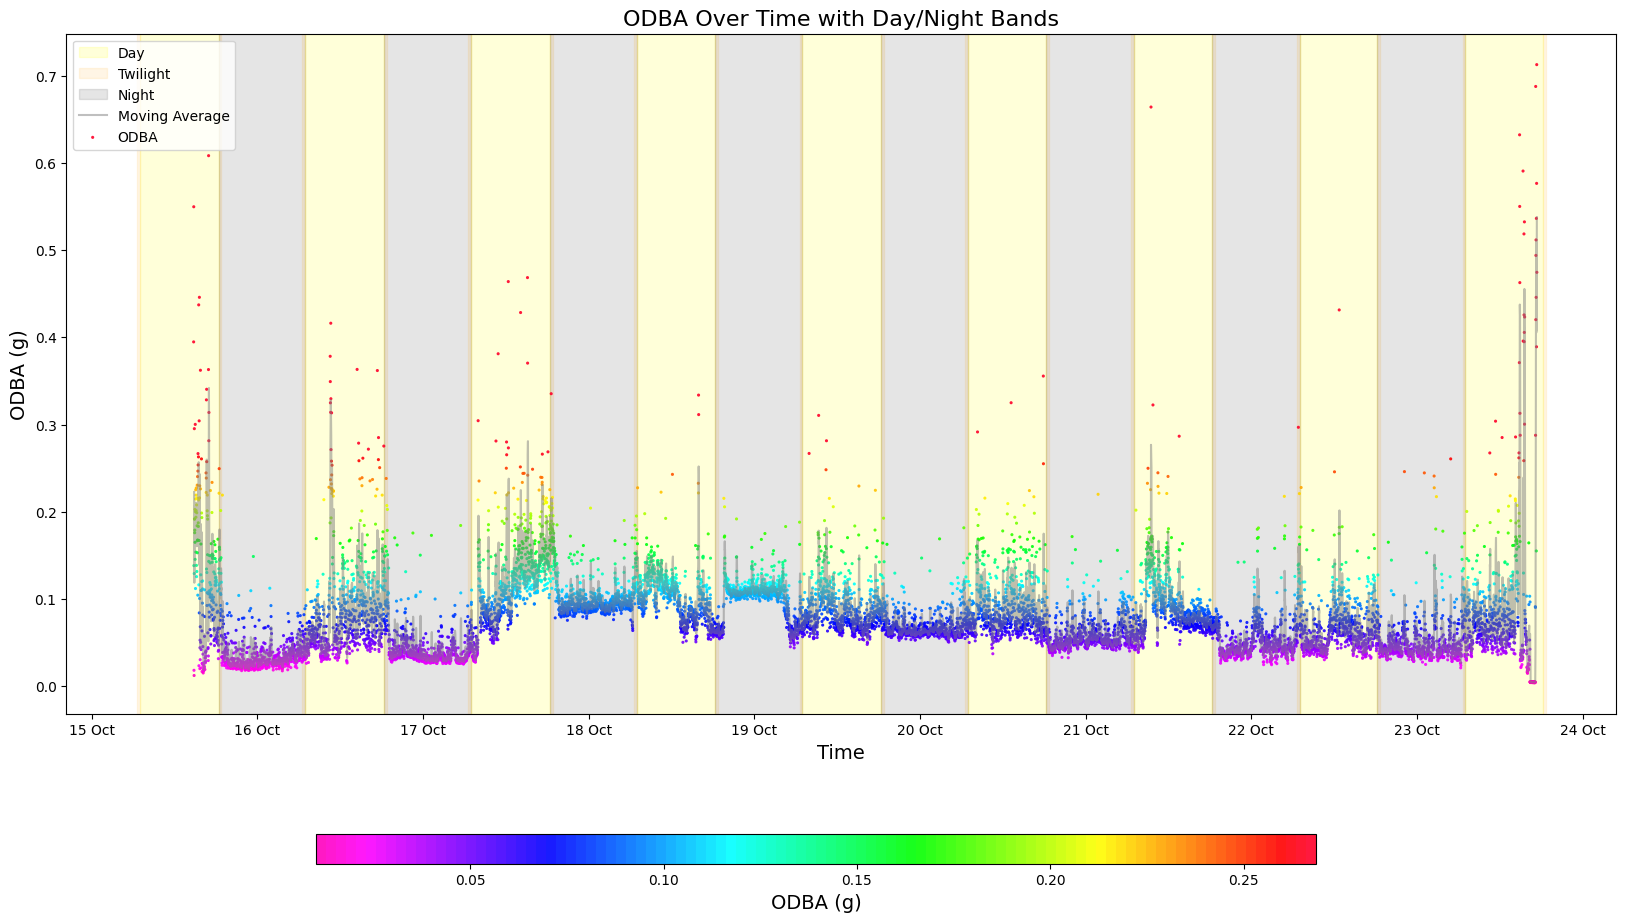

In [7]:
# Set plot size, titles and labels
plt.figure(figsize=(20, 10))
plt.xlabel('Time', fontsize=14)
plt.ylabel('ODBA (g)', fontsize=14)
plt.title('ODBA Over Time with Day/Night Bands', fontsize=16)

# Plot day-night bands
plot_day_night_bands(sun_cycles, plt.gca())

resampled_data = data.resample('min', on='Time Stamp').mean(numeric_only=True)

# Calculate the moving average of ODBA with a window size
window_size = 5
odba_moving_average = resampled_data['ODBA'].rolling(window=window_size).mean()

# Plot the moving average ODBA line
plt.plot(resampled_data.index, odba_moving_average, color='grey', alpha=0.5, label='Moving Average')

cmap = plt.get_cmap('gist_rainbow', 100).reversed()
lower_percentile = 2
upper_percentile = 98
lower_bound = data['ODBA'].quantile(lower_percentile / 100)
upper_bound = data['ODBA'].quantile(upper_percentile / 100)
norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)

# Scatter plot for ODBA values over time
sc = plt.scatter(resampled_data.index, resampled_data['ODBA'], s=5, alpha=0.9,
                      c=resampled_data['ODBA'], cmap=cmap, norm=norm, edgecolor='none', label='ODBA')

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Extract handles and labels for the legend from the current axis
handles, labels = plt.gca().get_legend_handles_labels()

# Create legend from handles and labels
plt.legend(handles, labels, loc='upper left')

# Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.20)

# Adjust the position of the colorbar
colorbar_axes = plt.gcf().add_axes([0.25, 0.05, 0.5, 0.03])

# Create the colorbar with the specified axes and orientation
cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')

# Set the label for the colorbar
cbar.set_label('ODBA (g)', fontsize=14)

# Show the plot
plt.show()

### Depth over Time with ODBA Color Coding

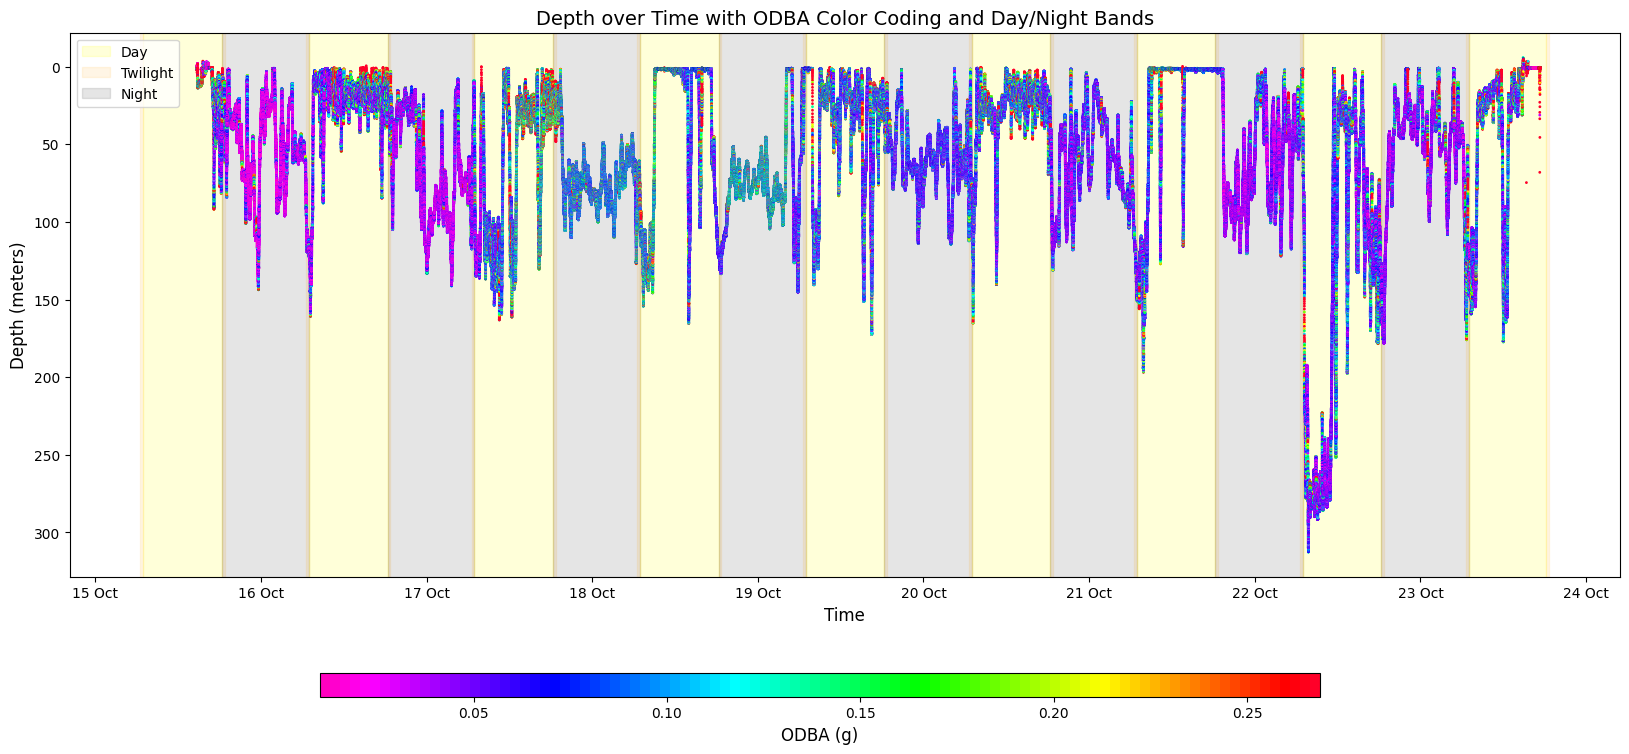

In [8]:
# Initialize plot
plt.figure(figsize=(20, 8))

# Plot day-night bands
plot_day_night_bands(sun_cycles, plt.gca())

# Use a predefined colormap
cmap = plt.get_cmap('gist_rainbow_r', 100)
lower_percentile = 2
upper_percentile = 98
lower_bound = data['ODBA'].quantile(lower_percentile / 100)
upper_bound = data['ODBA'].quantile(upper_percentile / 100)
norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)

# Plot depth data against time, colored by temperature
sc = plt.scatter(data['Time Stamp'], data['Pressure'], c=data['ODBA'], cmap=cmap, norm=norm, s=1, alpha=1.0)
plt.gca().invert_yaxis()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Extract handles and labels for the legend from the current axis
handles, labels = plt.gca().get_legend_handles_labels()

# Create legend from handles and labels
plt.legend(handles, labels, loc='upper left')

# Set plot titles and labels
plt.title('Depth over Time with ODBA Color Coding and Day/Night Bands', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Depth (meters)', fontsize=12)

# Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.20)

# Adjust the position of the colorbar
colorbar_axes = plt.gcf().add_axes([0.25, 0.05, 0.5, 0.03])

# Create the colorbar with the specified axes and orientation
cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')

# Set the label for the colorbar
cbar.set_label('ODBA (g)', fontsize=12)

# Show the plot
plt.show()

### Axis Values Over Time with ODBA Color Coding

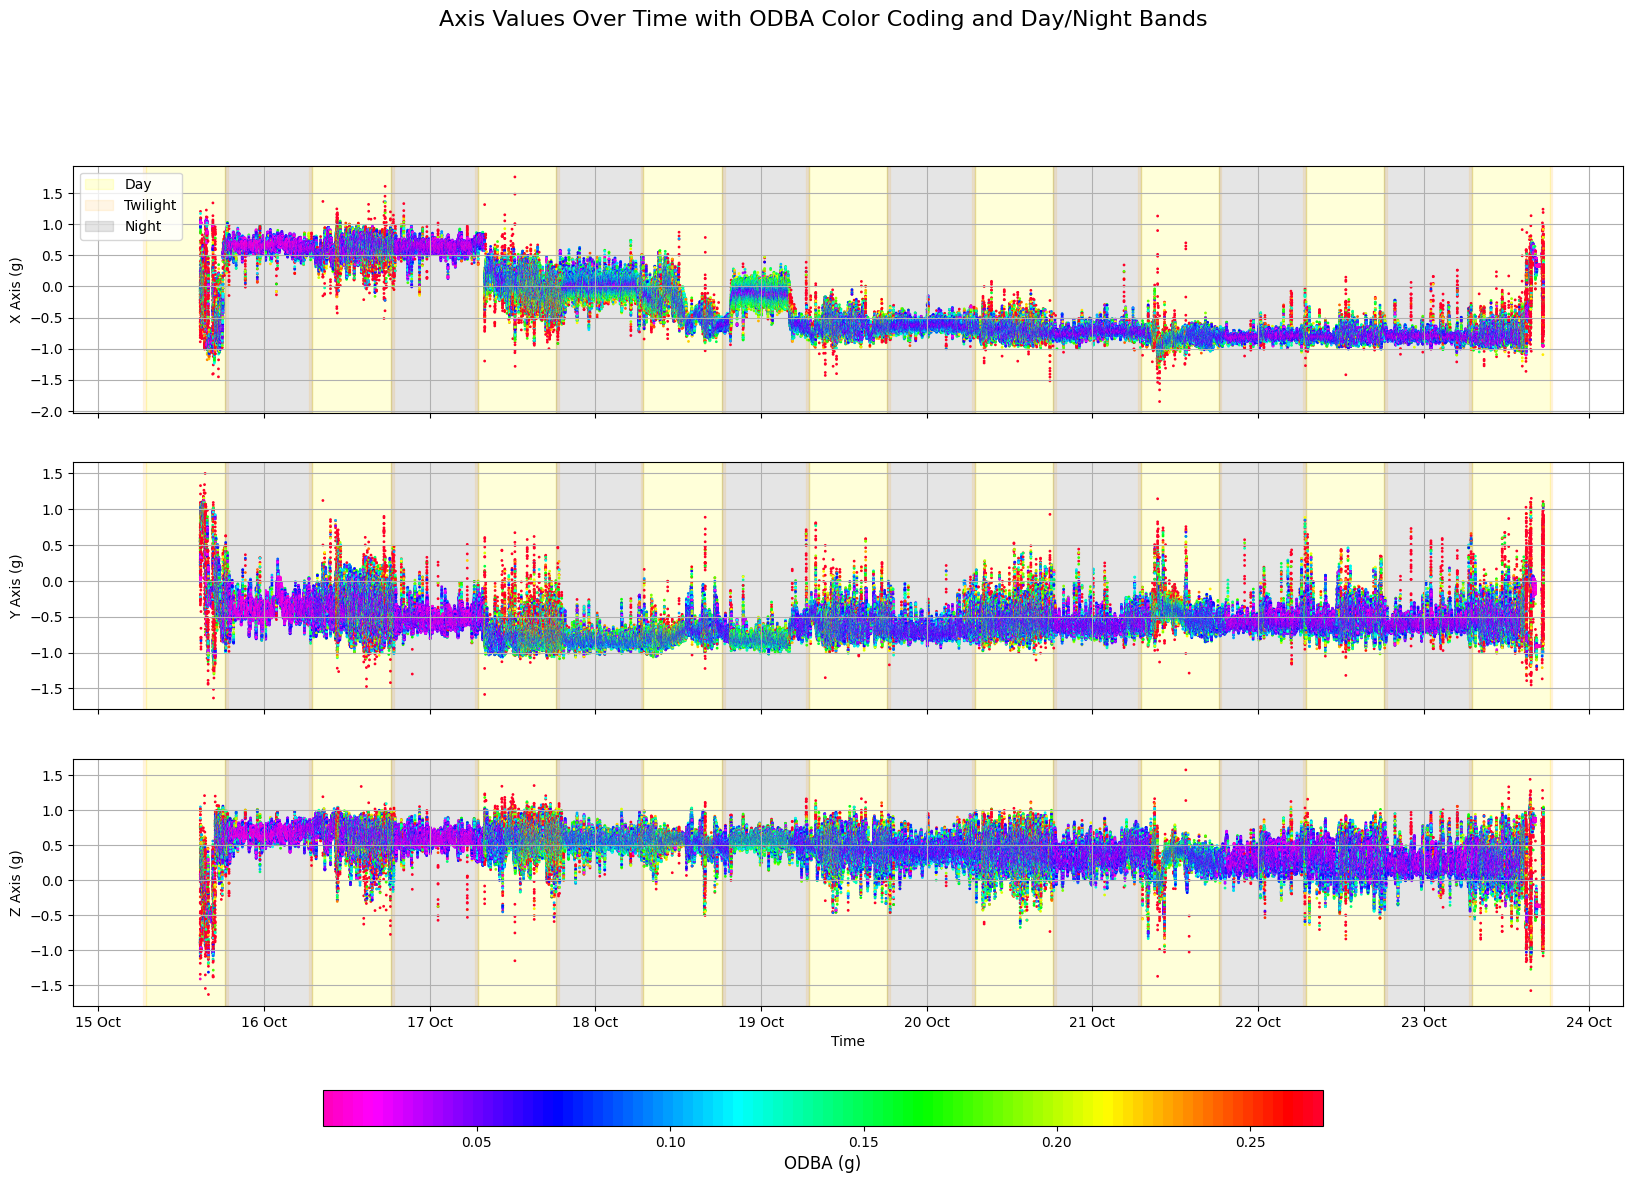

In [9]:
# Create a subplot layout
fig, axs = plt.subplots(3, 1, figsize=(20, 12), sharex=True)

# Store the day/night patches for the legend
day_patch = None
twilight_patch = None
night_patch = None

cmap = plt.get_cmap('gist_rainbow_r', 100)
lower_percentile = 2
upper_percentile = 98
lower_bound = data['ODBA'].quantile(lower_percentile / 100)
upper_bound = data['ODBA'].quantile(upper_percentile / 100)
norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)

for i, axis in enumerate(['X Axis', 'Y Axis', 'Z Axis']):
    # Call plot_day_night_bands for each subplot
    plot_day_night_bands(sun_cycles, axs[i])

    # Scatter plot for color-coded ODBA data
    sc = axs[i].scatter(data['Time Stamp'], data[axis], c=data['ODBA'], cmap=cmap, norm=norm, s=1, alpha=1.0)

    axs[i].set_ylabel(f'{axis} (g)')
    axs[i].grid(True)

    # Format the x-axis
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))

# After plotting on all subplots, extract handles and labels for the legend from the last axis
handles, labels = axs[-1].get_legend_handles_labels()

# Create legend from handles and labels and add it to the first subplot
axs[0].legend(handles, labels, loc='upper left')

# Set common X-Axis properties
axs[-1].set_xlabel('Time')

# Set the title for the entire figure
fig.suptitle('Axis Values Over Time with ODBA Color Coding and Day/Night Bands', fontsize=16)

# Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.20)

# Adjust the position of the colorbar
# These values are fractions of the figure size. (left, bottom, width, height)
colorbar_axes = fig.add_axes([0.25, 0.05, 0.5, 0.03])

# Create the colorbar with the specified axes and orientation
cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')
cbar.set_label('ODBA (g)', fontsize=12)

# Set the grid for better readability
for ax in axs:
    ax.grid(True)

# Adjust layout
fig.subplots_adjust(bottom=0.15, top=0.85)

# Show the plot
plt.show()

## Comparative Analysis
This section aims to compare the observed behaviors of shark #A14243 with existing literature on white shark behavior, particularly around Guadalupe Island.